In [2]:
import seaborn as sns
import pandas as pd
import esda
from pysal.lib import weights
from splot.esda import (
    moran_scatterplot, lisa_cluster, plot_local_autocorrelation, plot_moran
)
from splot.libpysal import plot_spatial_weights
import geopandas as gpd
import numpy as np
import contextily as cx
import matplotlib.pyplot as plt

import helper

In [ ]:
# read data
df = pd.read_csv('data/monthly/24_03.csv')
gdf_rides = helper.create_rides_gdf(df)
gdf_stations = helper.create_stations_gdf(df)
gdf_oslo_districts = helper.create_oslo_districts_gdf()

In [34]:
# read data
df = pd.read_csv('data/monthly/24_03.csv')
gdf_rides = helper.create_rides_gdf(df)
gdf_stations = helper.create_stations_gdf(df)
gdf_stations = gdf_stations.to_crs(epsg=3857)

gdf_oslo_kommuner = gpd.read_file('data/Oslo_Kommuner.geojson')
# Set the correct CRS
gdf_oslo_kommuner.set_crs('EPSG:32633', inplace=True, allow_override=True)

# Now you can convert to EPSG:3857
gdf_oslo_kommuner = gdf_oslo_kommuner.to_crs(epsg=3857)

# rename columns
gdf_oslo_kommuner = gdf_oslo_kommuner.rename(columns={'bydelnavn': 'district'})

/Users/niclasclassen/Code/Master/geospatial-ds-exam/helper.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rides["geometry"] = df_rides.apply(


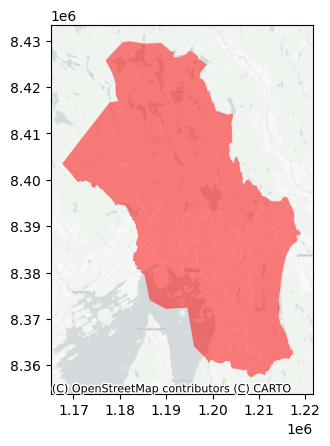

In [35]:
# Plot polygons
ax = gdf_oslo_kommuner.plot(alpha=0.5, color='red');
# Add background map, expressing target CRS so the basemap can be reprojected
cx.add_basemap(ax, crs=gdf_oslo_kommuner.crs, source=cx.providers.CartoDB.Positron)

In [36]:
import geopandas as gpd

# Perform a spatial join
joined = gpd.sjoin(gdf_oslo_kommuner, gdf_stations, how="inner", op='contains')

# Find the polygons that don't have any points inside them
no_points_inside = gdf_oslo_kommuner.loc[~gdf_oslo_kommuner.index.isin(joined.index)]

# Remove these polygons from gdf_oslo_kommuner
gdf_oslo_kommuner = gdf_oslo_kommuner.drop(no_points_inside.index)

/Users/niclasclassen/Code/Master/geospatial-ds-exam/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


/var/folders/sh/fjb1r_5j6gxcy4lzfcc4_4zr0000gn/T/ipykernel_3300/319263858.py:2: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax = gdf_oslo_kommuner.plot(alpha=0.5, color='red');
/Users/niclasclassen/Code/Master/geospatial-ds-exam/.venv/lib/python3.11/site-packages/contextily/tile.py:623: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


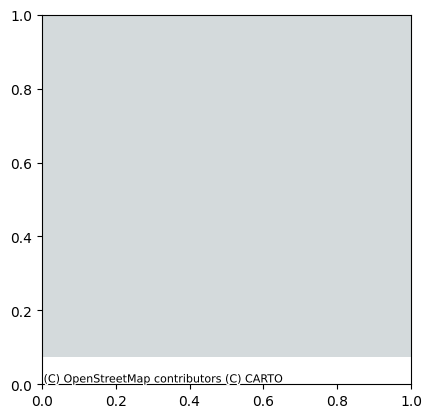

In [37]:
# Plot polygons
ax = gdf_oslo_kommuner.plot(alpha=0.5, color='red');
# Add background map, expressing target CRS so the basemap can be reprojected
cx.add_basemap(ax, crs=gdf_oslo_kommuner.crs, source=cx.providers.CartoDB.Positron)

**To get an initial idea of the distribution of the variable 'Pct_Leave', let's make a quick choropleth map:**

In [1]:
from geopandas.tools import sjoin

# Perform a spatial join between the stations and the districts
joined = sjoin(gdf_stations, gdf_oslo_kommuner, how='left', op='within')

# The 'district' column in 'joined' now contains the district of each station
gdf_stations['district'] = joined['district']

NameError: name 'gdf_stations' is not defined

In [30]:
# Group gdf_rides by 'start_station_id' and count the number of rides
start_rides = gdf_rides.groupby('start_station_id').size().reset_index(name='number_start_rides')

# Merge this information with gdf_stations on 'station_id'
gdf_stations = gdf_stations.merge(start_rides, left_on='station_id', right_on='start_station_id', how='left')

# Fill NaN values with 0, assuming that NaN means no rides started from the station
gdf_stations['number_start_rides'] = gdf_stations['number_start_rides'].fillna(0)

# Group gdf_rides by 'end_station_id' and count the number of rides
end_rides = gdf_rides.groupby('end_station_id').size().reset_index(name='number_end_rides')

# Merge this information with gdf_stations on 'station_id'
gdf_stations = gdf_stations.merge(end_rides, left_on='station_id', right_on='end_station_id', how='left')

# Fill NaN values with 0, assuming that NaN means no rides ended at the station
gdf_stations['number_end_rides'] = gdf_stations['number_end_rides'].fillna(0)
gdf_stations.shape

(267, 11)

In [31]:
gdf_oslo_kommuner.head()

,district,bydelnr,geometry
0,Frogner,030105,"MULTIPOLYGON (((1189421.693 8375826.292, 11864..."
1,Østensjø,030113,"MULTIPOLYGON (((1206718.020 8369118.365, 12067..."
2,Søndre Nordstrand,030115,"MULTIPOLYGON (((1210120.108 8358267.151, 12100..."
3,Marka,030117,"MULTIPOLYGON (((1214365.526 8369957.278, 12144..."
4,Sentrum,030116,"MULTIPOLYGON (((1196018.635 8377365.629, 11942..."


In [32]:
# Group and sum 'number_start_rides' in gdf_stations by 'district'
start_rides_by_district = gdf_stations.groupby('district')['number_start_rides'].sum().reset_index()

# Merge this DataFrame with gdf_oslo_kommuner
gdf_oslo_kommuner = gdf_oslo_kommuner.merge(start_rides_by_district, on='district', how='left')

# Group and sum 'number_end_rides' in gdf_stations by 'district'
end_rides_by_district = gdf_stations.groupby('district')['number_end_rides'].sum().reset_index()

# Merge this DataFrame with gdf_oslo_kommuner
gdf_oslo_kommuner = gdf_oslo_kommuner.merge(end_rides_by_district, on='district', how='left')

/Users/niclasclassen/Code/Master/geospatial-ds-exam/.venv/lib/python3.11/site-packages/mapclassify/classifiers.py:1592: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 1.
  self.bins = quantile(y, k=k)
/Users/niclasclassen/Code/Master/geospatial-ds-exam/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/niclasclassen/Code/Master/geospatial-ds-exam/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation minimum which has no identity

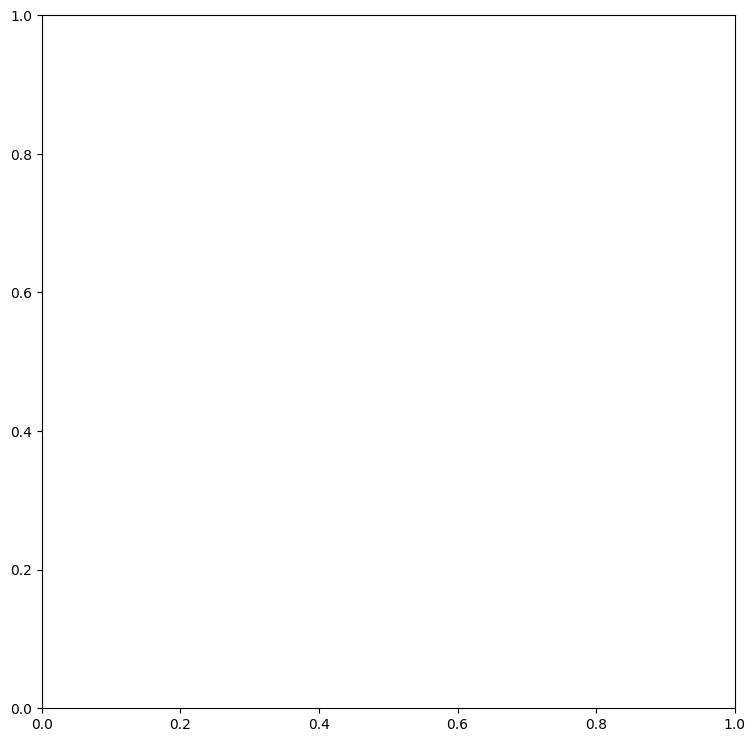

In [33]:
f, ax = plt.subplots(1, figsize=(9, 9))
gdf_oslo_kommuner.plot(
    column="number_start_rides",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.5,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax,
)
cx.add_basemap(
    ax,
    crs=gdf_oslo_kommuner.crs,
    source=cx.providers.CartoDB.Positron
)
ax.set_axis_off()

/var/folders/sh/fjb1r_5j6gxcy4lzfcc4_4zr0000gn/T/ipykernel_3300/3651538886.py:2: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf_oslo_kommuner.plot(


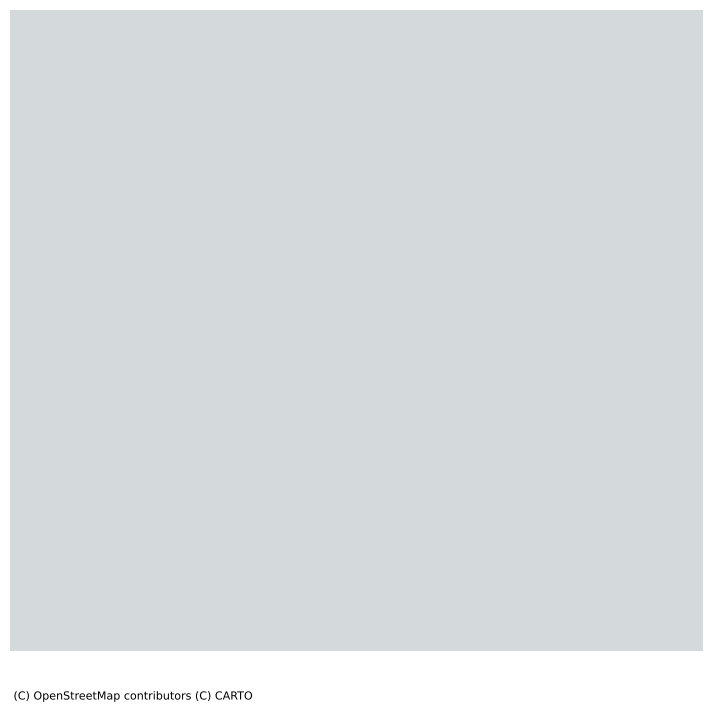

In [12]:
f, ax = plt.subplots(1, figsize=(9, 9))
gdf_oslo_kommuner.plot(
    column="number_end_rides",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.5,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax,
)
cx.add_basemap(
    ax,
    crs=gdf_oslo_kommuner.crs,
    source=cx.providers.CartoDB.Positron
)
ax.set_axis_off()

In [15]:
w = weights.Queen.from_dataframe(gdf_oslo_kommuner, idVariable='district')

# Calculate Moran's I
# Adjust 'number_start_rides' to your actual variable of interest
moran = esda.Moran(gdf_oslo_kommuner['number_start_rides'], w)

# Print Moran's I statistic and p-value
print(f"Moran's I: {moran.I}, p-value: {moran.p_sim}")


Moran's I: 0.17371401178617832, p-value: 0.063


/var/folders/sh/fjb1r_5j6gxcy4lzfcc4_4zr0000gn/T/ipykernel_31029/3431159764.py:1: FutureWarning: `idVariable` is deprecated and will be removed in future. Use `ids` instead.
  w = weights.Queen.from_dataframe(gdf_oslo_kommuner, idVariable='district')


/Users/niclasclassen/Code/Master/geospatial-ds-exam/.venv/lib/python3.11/site-packages/spaghetti/network.py:42: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)
/Users/niclasclassen/Code/Master/geospatial-ds-exam/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/sh/fjb1r_5j6gxcy4lzfcc4_4zr0000gn/T/ipykernel_31029/2435481319.py:6: FutureWarning: `idVari

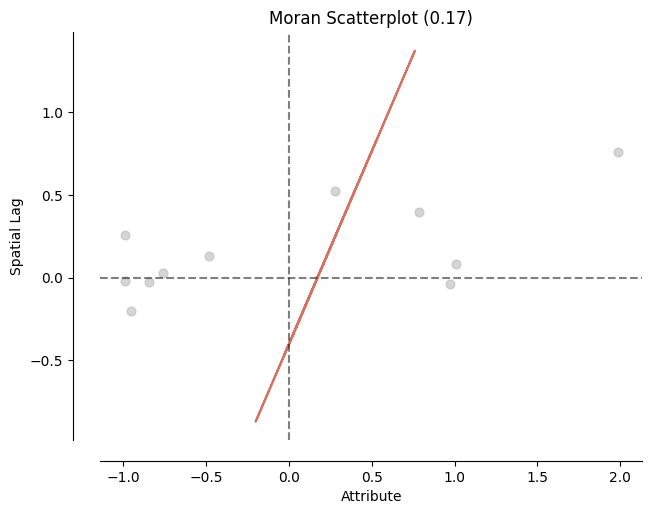

In [16]:
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import moran_scatterplot

# Create a weights object
w = weights.Queen.from_dataframe(gdf_oslo_kommuner, idVariable='district')

# Calculate Moran's I
moran = esda.Moran(gdf_oslo_kommuner['number_start_rides'], w)

# Create a Moran's plot
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

In [17]:
from pysal.lib import weights
from pysal.explore import esda

# Create a weights object
# Adjust 'geometry' to your actual geometry column
w = weights.Queen.from_dataframe(gdf_stations, idVariable='station_id')

# Calculate Moran's I
# Adjust 'number_start_rides' to your actual variable of interest
moran = esda.Moran(gdf_stations['number_end_rides'], w)

# Print Moran's I statistic and p-value
print(f"Moran's I: {moran.I}, p-value: {moran.p_sim}")

Moran's I: 0.48316158049127517, p-value: 0.001


/var/folders/sh/fjb1r_5j6gxcy4lzfcc4_4zr0000gn/T/ipykernel_31029/1689871690.py:6: FutureWarning: `idVariable` is deprecated and will be removed in future. Use `ids` instead.
  w = weights.Queen.from_dataframe(gdf_stations, idVariable='station_id')


/var/folders/sh/fjb1r_5j6gxcy4lzfcc4_4zr0000gn/T/ipykernel_31029/3657269178.py:6: FutureWarning: `idVariable` is deprecated and will be removed in future. Use `ids` instead.
  w = weights.Queen.from_dataframe(gdf_stations, idVariable='station_id')


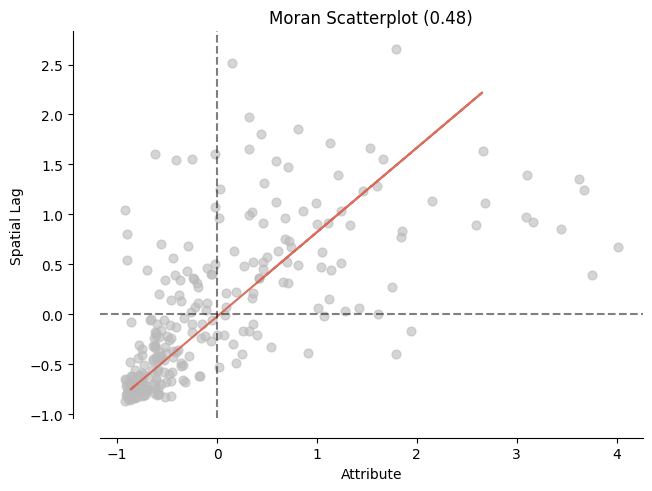

In [18]:
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import moran_scatterplot

# Create a weights object
w = weights.Queen.from_dataframe(gdf_stations, idVariable='station_id')

# Calculate Moran's I
moran = esda.Moran(gdf_stations['number_end_rides'], w)

# Create a Moran's plot
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

## KNN better for points

Moran's I: 0.4390593368061951, p-value: 0.001


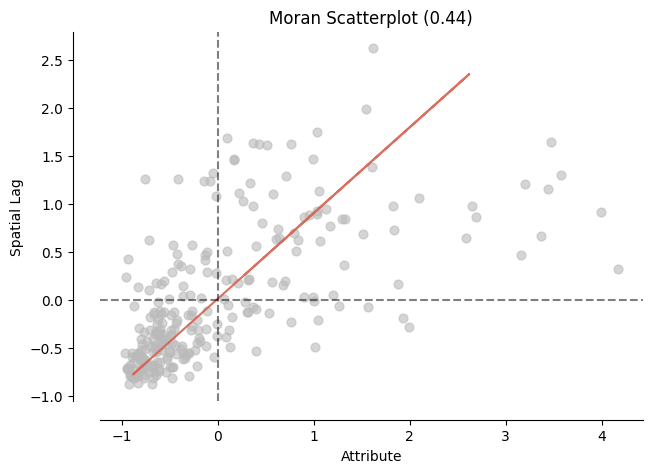

In [19]:
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import moran_scatterplot

# Create a weights object using k-nearest neighbors
w = weights.KNN.from_dataframe(gdf_stations, k=5, ids='station_id')

# Calculate Moran's I
moran = esda.Moran(gdf_stations['number_start_rides'], w)

# Print Moran's I statistic and p-value
print(f"Moran's I: {moran.I}, p-value: {moran.p_sim}")

# Create a Moran's plot
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

/var/folders/sh/fjb1r_5j6gxcy4lzfcc4_4zr0000gn/T/ipykernel_31029/1430252352.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(gdf_oslo_kommuner)


(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

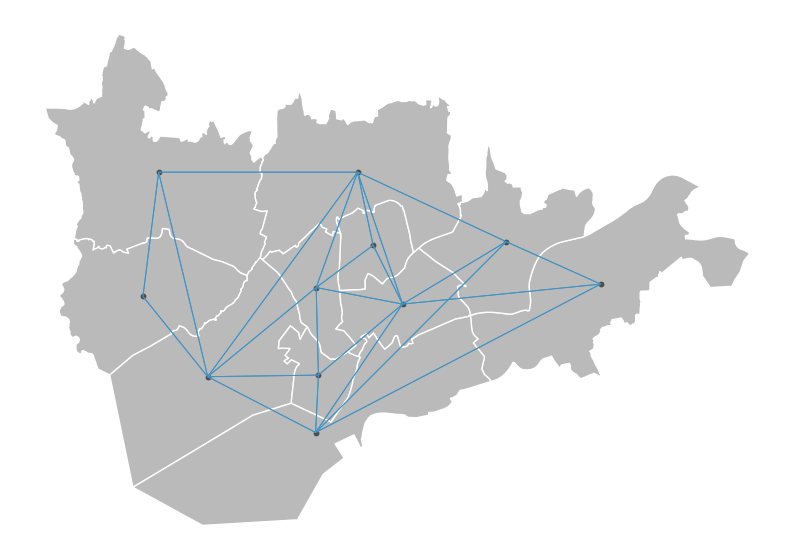

In [20]:
import libpysal
# Create a spatial weights object
w = libpysal.weights.Queen.from_dataframe(gdf_oslo_kommuner)

# Plot the spatial weights
plot_spatial_weights(w, gdf_oslo_kommuner)

In [21]:
# Create a spatial weights object
w = libpysal.weights.Queen.from_dataframe(gdf_oslo_kommuner)

# Standardize the spatial weights object
w.transform = 'r'

# Perform spatial autocorrelation analysis
moran = esda.Moran(gdf_oslo_kommuner['number_start_rides'], w)

# Print Moran's I statistic and p-value
print(f"Moran's I: {moran.I}, p-value: {moran.p_sim}")

Moran's I: 0.17371401178617835, p-value: 0.062


/var/folders/sh/fjb1r_5j6gxcy4lzfcc4_4zr0000gn/T/ipykernel_31029/2860980518.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(gdf_oslo_kommuner)
